# Time series analysis - Content list
1. Import libraries and data
2. Create subsets
3. Decomposition
4. Test for stationarity
5. Check for autocorrelations

# 1. Import libraries and data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [2]:
# Import Data
# Create path
path = r'C:\Users\Mathilde\Documents\DATA ANALYSIS CAREERFOUNDRY\Aug 2024 - SNCF project'
# Import the merged data set
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared data', 'dataset_formatted.csv'), index_col = False)

In [3]:
pd.set_option('display.max_columns', None)
df.head(1)

,Unnamed: 0.1,Unnamed: 0,Date,Service,Departure station,Arrival station,Avg trip length,Number of trips scheduled,Number of trains cancelled,Number of trains delayed on departure,Avg delay of trains delayed on departure,Avg delay of all trains on departure,Number of trains delayed on arrival,Avg delay of trains delayed on arrival,Avg delay of all trains on arrival,Comments delay on arrival,Number of trains >15 min delay,Number of trains >30 min delay,Number of trains >60 min delay,% delay from external causes,% delay infrastructure cause,% delay traffic management cause,% delay rolling stock cause,% delay station management and reutilization of stock,"% delay because of accommodation of passengers (crowd, disability, connections)",Departure region,Arrival region,Departure station: Total travelers 2023,Departure station: Total travelers 2022,Departure station: Total travelers 2021,Departure station: Total travelers 2020,Departure station: Total travelers 2019,Departure station: Total travelers 2018,Arrival station: Total travelers 2023,Arrival station: Total travelers 2022,Arrival station: Total travelers 2021,Arrival station: Total travelers 2020,Arrival station: Total travelers 2019,Arrival station: Total travelers 2018
0,0,0,2018-01,National,Bordeaux Saint-Jean,Paris Montparnasse,141,870,5,289,11.247809,3.693179,147,28.436735,6.511118,NaN,110,44,8,36.134454,31.092437,10.92437,15.966387,5.042017,0.840336,Nouvelle-Aquitaine,Ile-de-France,22612374.0,21353889.0,16454662.0,11184093.0,17675655.0,16080989.0,64471254.0,56862435.0,41039816.0,32447396.0,61374056.0,59174533.0


In [4]:
# Drop some useless columns and re-export new version
df = df.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])
df.to_csv(os.path.join(path, '02 Data','Prepared Data', 'delay_tgv_final.csv'))
df.head(1)

,Date,Service,Departure station,Arrival station,Avg trip length,Number of trips scheduled,Number of trains cancelled,Number of trains delayed on departure,Avg delay of trains delayed on departure,Avg delay of all trains on departure,Number of trains delayed on arrival,Avg delay of trains delayed on arrival,Avg delay of all trains on arrival,Comments delay on arrival,Number of trains >15 min delay,Number of trains >30 min delay,Number of trains >60 min delay,% delay from external causes,% delay infrastructure cause,% delay traffic management cause,% delay rolling stock cause,% delay station management and reutilization of stock,"% delay because of accommodation of passengers (crowd, disability, connections)",Departure region,Arrival region,Departure station: Total travelers 2023,Departure station: Total travelers 2022,Departure station: Total travelers 2021,Departure station: Total travelers 2020,Departure station: Total travelers 2019,Departure station: Total travelers 2018,Arrival station: Total travelers 2023,Arrival station: Total travelers 2022,Arrival station: Total travelers 2021,Arrival station: Total travelers 2020,Arrival station: Total travelers 2019,Arrival station: Total travelers 2018
0,2018-01,National,Bordeaux Saint-Jean,Paris Montparnasse,141,870,5,289,11.247809,3.693179,147,28.436735,6.511118,NaN,110,44,8,36.134454,31.092437,10.92437,15.966387,5.042017,0.840336,Nouvelle-Aquitaine,Ile-de-France,22612374.0,21353889.0,16454662.0,11184093.0,17675655.0,16080989.0,64471254.0,56862435.0,41039816.0,32447396.0,61374056.0,59174533.0


# 2. Create subsets

For each time stamp (month), I have many rows: one for each existing TGV line. To conduct the time series analysis, I need to end up with one value for each month. I can group by date and take the average delay/number of trains cancelled, or a could select a specific line and check how the delay evolved across time. 

I'm going do group by date, in order to have a global view, and I'm going to select the variables "Avg delay of all trains on arrival", because it seems to be the most representative of the traveler's experience with delays, and "Number of trains cancelled" to get some insights on cancellations.

In [5]:
# Create subsets with the desired columns
df_sub_delay = df[['Date', 'Avg delay of all trains on arrival']]
df_sub_cancel = df[['Date', 'Number of trains cancelled']]

In [6]:
# Group by date with the mean of the avg delay/mean of number of trains calcelled
df_sub_delay = df_sub_delay.groupby('Date')['Avg delay of all trains on arrival'].mean()
df_sub_cancel = df_sub_cancel.groupby('Date')['Number of trains cancelled'].mean()

In [7]:
df_sub_delay.head()

Date
2018-01    5.829815
2018-02    8.762260
2018-03    5.599292
2018-04    5.659676
2018-05    6.680048
Name: Avg delay of all trains on arrival, dtype: float64

Our subsets are Series, and we need to turn them into a panda DataFrame with "Date" as index.

In [8]:
# Turn subsets into data frame
df_sub_delay = df_sub_delay.reset_index()
df_sub_cancel = df_sub_cancel.reset_index()
df_sub_delay

,Date,Avg delay of all trains on arrival
0,2018-01,5.829815
1,2018-02,8.762260
2,2018-03,5.599292
3,2018-04,5.659676
4,2018-05,6.680048
...,...,...
73,2024-02,5.130389
74,2024-03,6.165686
75,2024-04,6.203363
76,2024-05,4.938001


In [9]:
# Put "Date" as index for df_sub_delay
df_sub_delay['datetime'] = pd.to_datetime(df_sub_delay['Date']) # Create a datetime column from "Date.""
df_sub_delay = df_sub_delay.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub_delay.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub_delay.head()

,Avg delay of all trains on arrival
datetime,
2018-01-01,5.829815
2018-02-01,8.762260
2018-03-01,5.599292
2018-04-01,5.659676
2018-05-01,6.680048


In [10]:
# Put "Date" as index for df_sub_cancel
df_sub_cancel['datetime'] = pd.to_datetime(df_sub_cancel['Date']) # Create a datetime column from "Date.""
df_sub_cancel = df_sub_cancel.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub_cancel.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub_cancel.head()

,Number of trains cancelled
datetime,
2018-01-01,2.046154
2018-02-01,5.638462
2018-03-01,7.146154
2018-04-01,91.084615
2018-05-01,68.153846


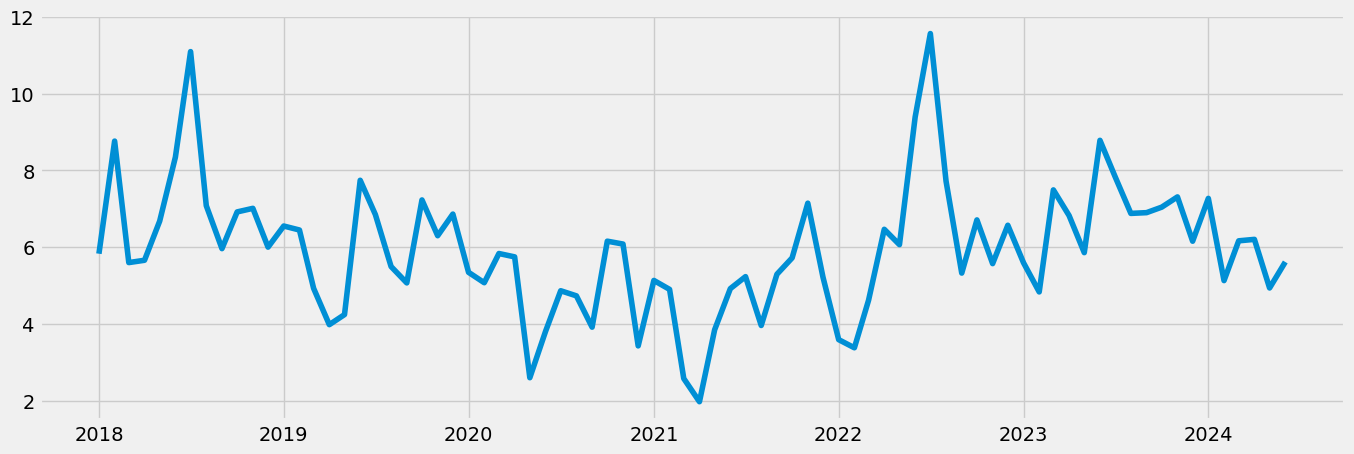

In [13]:
# Plot the new data set - DELAY
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub_delay)

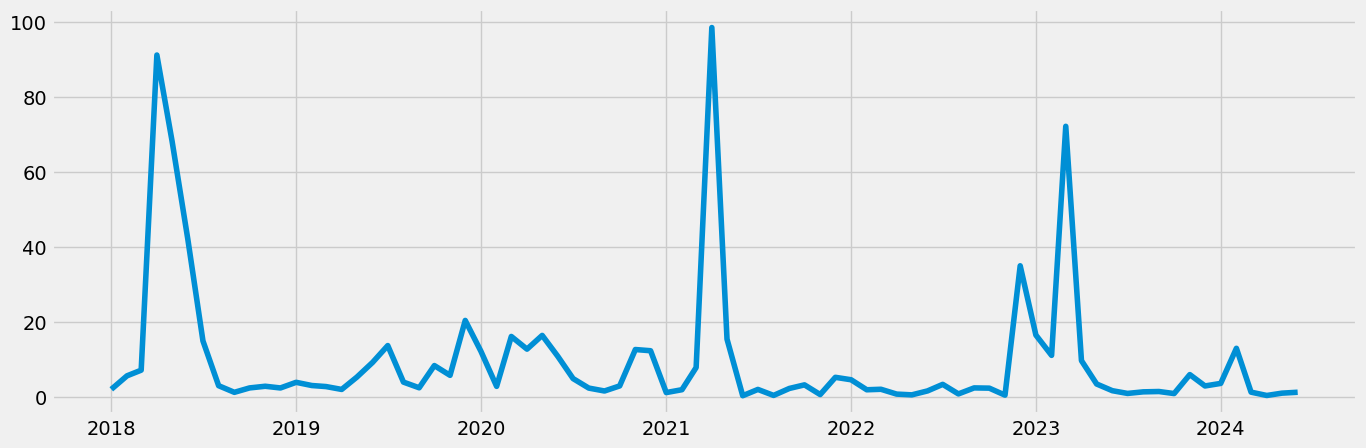

In [12]:
# Plot the new data set - CANCEL
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub_cancel)

### Observation:
**DELAY:** There seems to be a big seasonal component. It looks like there's a downward trend until 2021, and an upward trend from 2021. Let's check in detail.
**CANCELLATIONS:** The profile is very different.There are 3 big peaks in 2018, 2021 and 2023. They are very likely due to social movements and strikes, that the French railway system is famous for. There seems to be some seasonality, but it is harder to see because of the peaks.

# 3. Decomposition - Delay

The changes behave in a linear fashion, not exponential. We'll use an additive model.

In [14]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub_delay, model='additive')

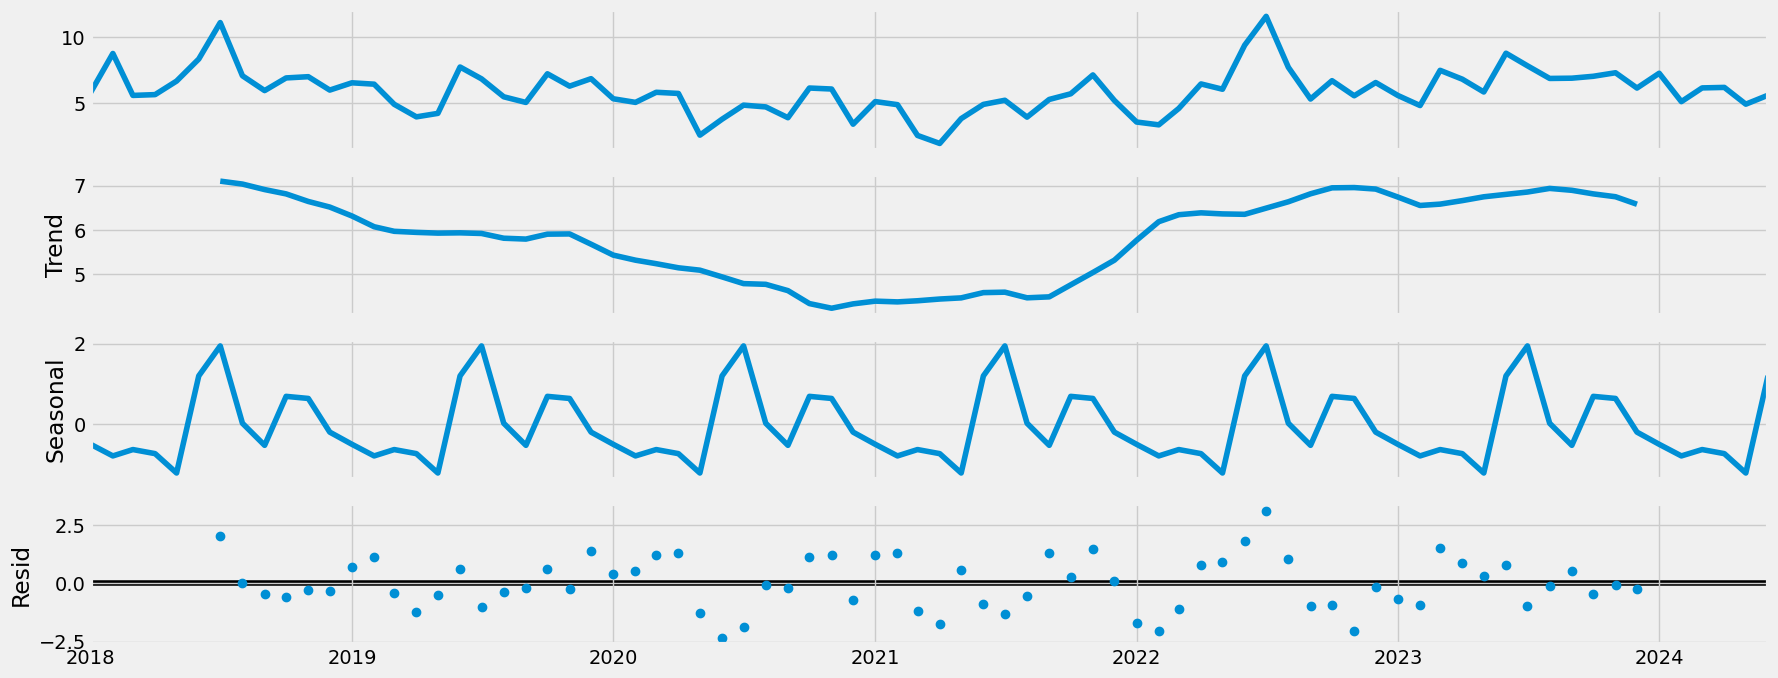

In [15]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7
# Plot the separate components
decomposition.plot()
plt.show()

### Observations:
* There is a strong seasonality: a peak in the avregage delay in July, then a drop, then another peak in October. This is pretty surprising. I expected more delay during summer holidays, when the staff on vacation, but I don't see why there is another peak in October/November. This is interesting!
* There is, indeed, a downward trend until 2021, and then an upward one. The data is, apparently, not stationary, but let's veryfy this with a statistical test. 

# 4. Test for stationarity - Delay

In [17]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub_delay['Avg delay of all trains on arrival'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.110001
p-value                         0.025822
Number of Lags Used             2.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


### Interpretation of the Dickey-Fuller Stationarity test:
Our Test Statistic, -3.110001, is smaller than the 10% and 5% critical value, which means that we can reject the null hypothesis (which is: the data is not stationnary) with a certitude of 95%. Our p-value is less than 0.05, which means that the result is significant. **We can consider the series stationnary.**

# 5. Check for autocorrelations  - Delay

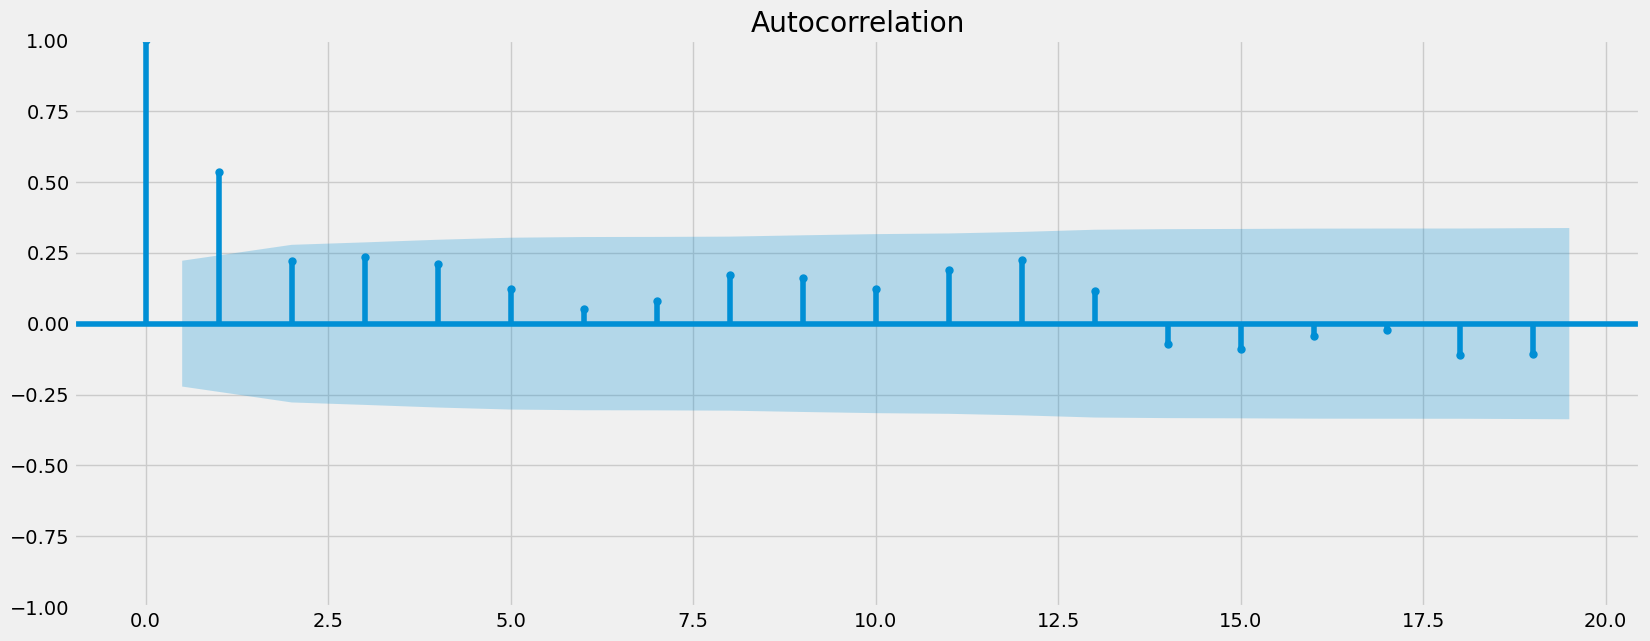

In [18]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_sub_delay)
plt.show()

### Interpretation:
We have 2 lags that are above the confidence interval, which means the data is not perfectly stationnary. It is, however, a small enough number of lags, and no differencing is necessary.

# 6. Decomposition - Cancellations

The changes behave in a linear fashion, not exponential. We'll use an additive model.

In [20]:
# Decompose the time series using an additive model
decomposition2 = sm.tsa.seasonal_decompose(df_sub_cancel, model='additive')

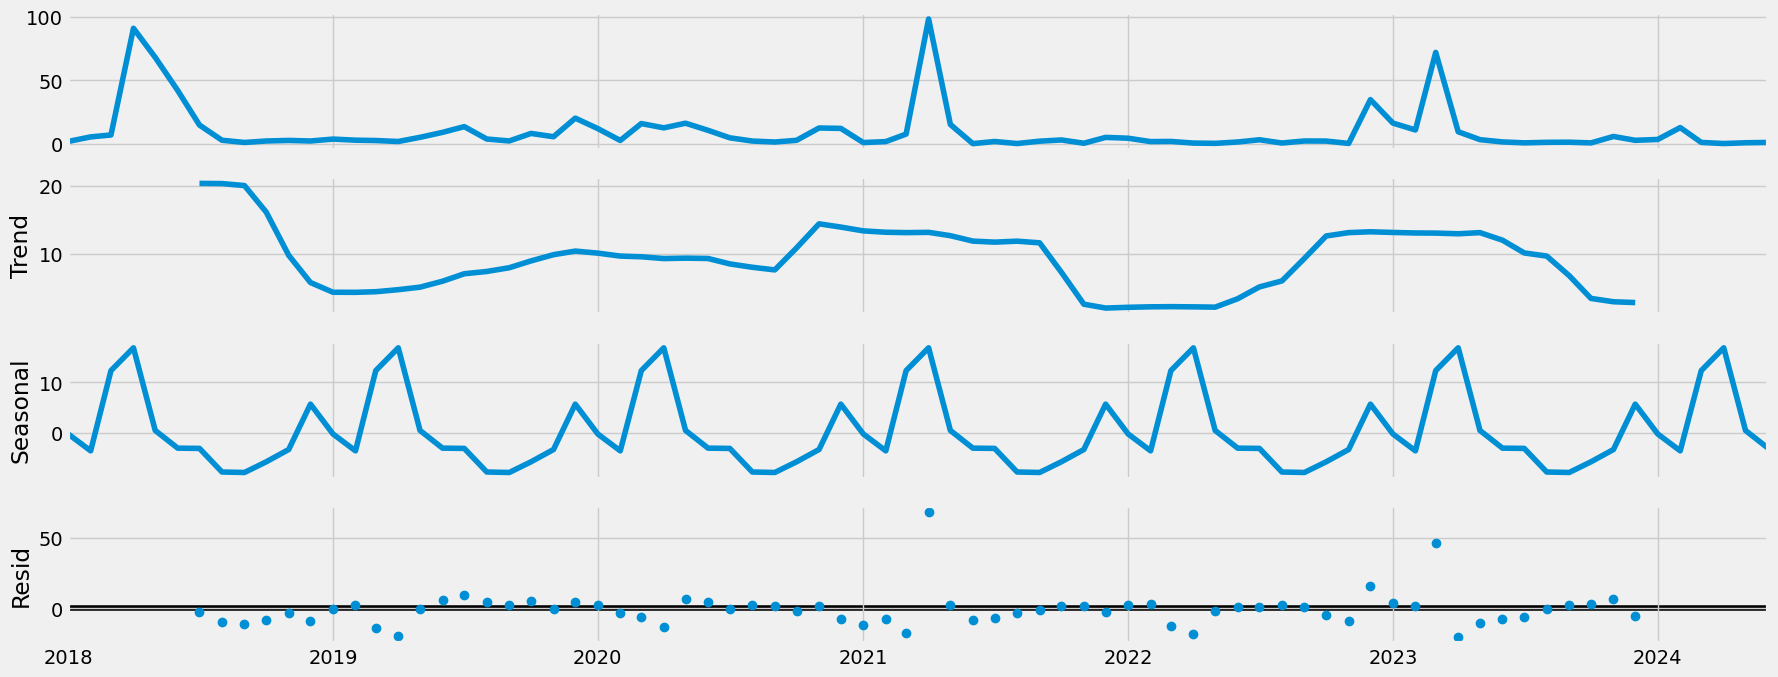

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7
# Plot the separate components
decomposition2.plot()
plt.show()

### Observations:
* There is a strong seasonality: a peak in the number of cancellations in April, and another one in November. This is again quite a surprise!
* There are two "peaks" in the noise in 2021 and in 2023, that correspond to the peaks observed earlier. They match with the dates of two big social movements in France due to the reform of pensions.
* No particular trend to be observed. The series is probable stationnary, but let's verify with a statistical test.

# 7. Test for stationarity - Cancellations

In [23]:
# Apply the test using the function on the time series
dickey_fuller(df_sub_cancel['Number of trains cancelled'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.052056e+00
p-value                        1.270662e-07
Number of Lags Used            0.000000e+00
Number of Observations Used    7.700000e+01
Critical Value (1%)           -3.518281e+00
Critical Value (5%)           -2.899878e+00
Critical Value (10%)          -2.587223e+00
dtype: float64


### Interpretation of the Dickey-Fuller Stationarity test:
Our Test Statistic, -6.052056, is smaller than the 10%, 5% and the 1% critical value, which means that we can reject the null hypothesis (which is: the data is not stationnary) with a certitude of 99%. Our p-value is much less than 0.05, which means that the result is very significant. **We can consider the series stationnary.**

# 8. Check for autocorrelations - Cancellations

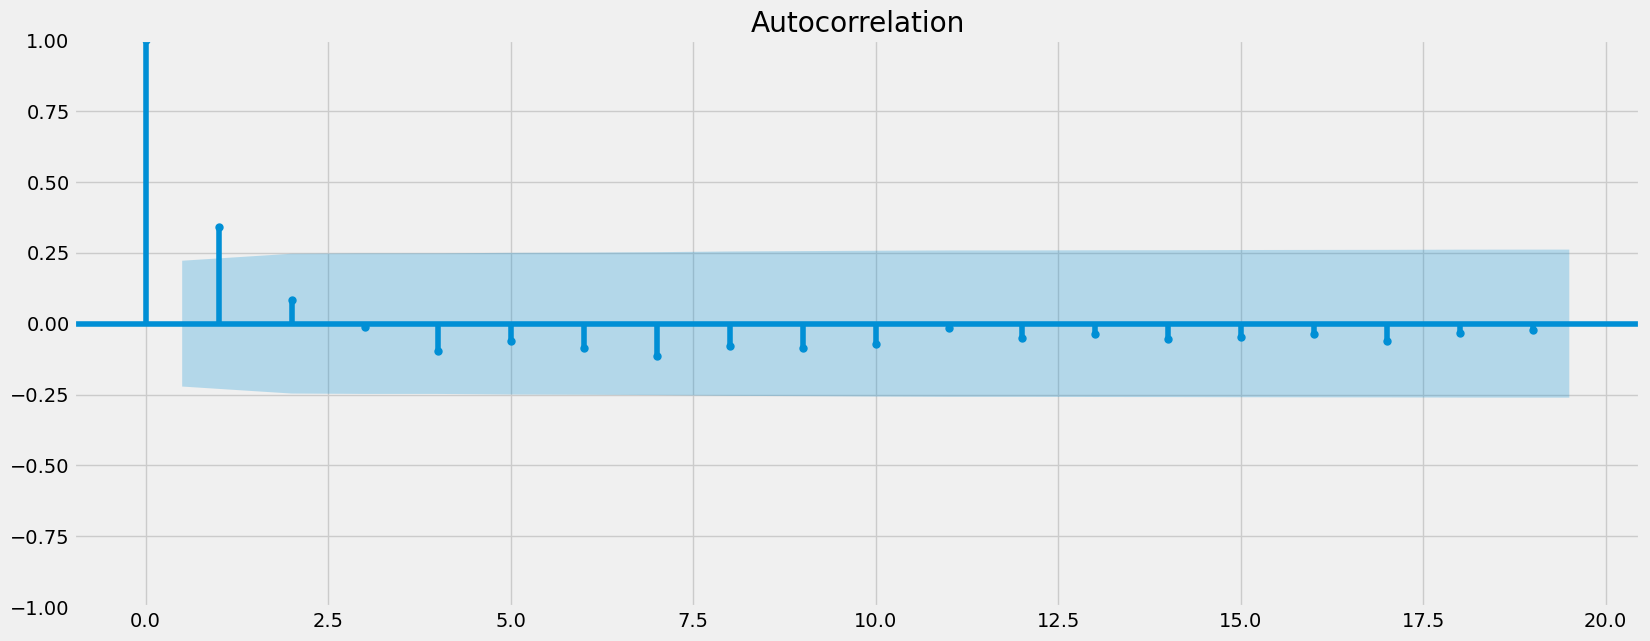

In [24]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_sub_cancel)
plt.show()

### Interpretation:
We have 2 lags that are above the confidence interval, which means the data is not perfectly stationnary. It is, however, a small enough number of lags, and no differencing is necessary.